### The Wave equation

We study the 1-dimensional elastic wave equation:
\begin{equation}
\rho(x)\frac{d^2}{dt}u(x,t) = \frac{d}{dx}\big{(}\mu(x)\frac{d}{dx}u(x,t)\big{)} + f(x,t)
\end{equation}
and we will solve it using the finite element method and spectral element method.
Since the focus is on the numerical method, some mathematical details will be omitted to speed up the exposition.

The weak form of the equation (on a domain $D$, with test functions $\varphi$ and assuming some things when doing integration by parts) is given by:
\begin{equation}
  \int_D \rho(x)\frac{d^2}{dt}u(x,t) \varphi(x) dx +  \int_D \mu(x)\frac{d}{dx}u(x,t) \frac{d}{dx}\varphi(x) dx= \int_D f(x,t) \varphi(x) dx
\end{equation}

$\rho$ and $\mu$ are assumed constant in this notebook.

More detailed explanation still to come.

In [1]:
#Libraries 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("nbagg")

from numpy.polynomial import Legendre
from ricker import ricker
%run Wave-SEM.py

In [2]:
# Initialisation - set paramaters 
N = 3                 # Order of interpolating lagrange polynomials 
nt    = 600           # number of time steps
xmax  = 10000.        # Length of domain [m]
vs    = 2500.         # S velocity [m/s]
rho   = 2000          # Density [kg/m^3]
mu    = rho * vs**2   # Shear modulus mu
ne    = 150           # Number of elements
center_freq = 15      # Center frequency of the Ricker wavelet
iplot = 5             # Plotting each iplot snapshot

<IPython.core.display.Javascript object>


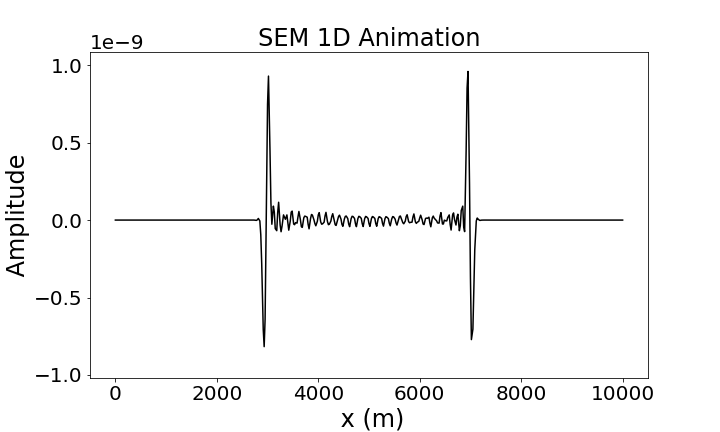

In [5]:
# Elemental Mass matrix
Me = np.zeros(N+1, dtype=float)
# Elemental Stiffness matrix
Ke = np.zeros((N+1,N+1), dtype=float)
# Gauss-Lobatto-Legendre points and weights
xi, w = gll(N)
# Lenght of element
le = xmax/ne
# nr of grid points
ngrid = ne*N + 1
# Domain/grid points
x = np.zeros(ngrid)
k = 0
x[0] = 0.
for i in range(1,ne+1):
    for j in range(0, N):
        k = k + 1
        x[k]=(i-1)*le + (xi[j+1]+1)*0.5*le # map xi points [-1,1] to each element
        
# Jacobian values (constant since all elements have the same size)
J = le/2
Jinv = 1/J

# Calculate time step
dxmin = min(np.diff(x))  
eps = 0.2           # Courant value
dt = eps*dxmin/vs   # Global time step

# Mass matrix calculations
###########################
# Elemental mass matrix
for i in range(0,N+1):
    Me[i] = rho * J * w[i]

# Global mass matrix
M = np.zeros(ngrid)
k = -1
for i in range(1, ne+1):
    for j in range(0,N+1):
        k = k + 1
        if i>1:
            if j==0:
                k = k - 1
        M[k] = M[k] + Me[j]
Minv = np.identity(ngrid)
for i in range(0,ngrid):
    Minv[i,i] = 1/M[i]

# Stiffness matrix calculations
################################
#Elemental stiffness matrix
for i in range(0,N+1):
    for j in range(0,N+1):
        for k in range(0,N+1):
            Ke[i,j] = Ke[i,j] + mu * w[k] * Jinv * lag_deriv(xi[k], i, xi) * lag_deriv(xi[k], j, xi)

K = np.zeros([ngrid,ngrid], dtype=float)

# Global Stiffness Matrix
# Values except at element boundaries 
for k in range(1,ne+1):
    i0 = (k-1)*N + 1
    j0 = i0
    for i in range(-1,N):
        for j in range(-1,N):
            K[i0+i,j0+j] = Ke[i+1,j+1]
            
# Values at element boundaries 
for k in range(2,ne+1):
    i0 = (k - 1)*N
    j0 = i0
    K[i0,j0] = Ke[0,0] + Ke[N,N]
    
# Assembly
u = np.zeros(ngrid)
f = np.zeros(ngrid)
uold = np.zeros(ngrid)
unew = np.zeros(ngrid)

# initialize source time function and force vector f
# A ricker wavelet is used as an example
src  = ricker(f=center_freq, len=100*dt, dt=dt, peak_loc=50*dt)
loc_src = int(np.floor(ngrid/2))   # Source location

# --------------------------------------------------------------
# Initialize animated plot
# --------------------------------------------------------------
plt.figure(figsize=(10,6))
lines = plt.plot(x, u, lw=1.5)
plt.title('SEM 1D Animation', size=24)
plt.xlabel(' x (m)', size=24)
plt.ylabel(' Amplitude ', size=24)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.ion() # set interactive mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
for it in range(nt): 
    f= np.zeros(ngrid)
    if it < len(src):
        f[loc_src-1] = src[it-1] 
               
    # Time extrapolation
    unew = dt**2 * Minv @ (f - K @ u) + 2 * u - uold
    uold, u = u, unew

    # --------------------------------------   
    # Animation plot. Display solution 
    if not it % iplot:
        for l in lines:
            l.remove()
            del l
        # -------------------------------------- 
        # Display lines            
        lines = plt.plot(x, u, color="black", lw = 1.5)
        plt.gcf().canvas.draw()       